# DCGAN on Bricks Dataset

In [10]:
import os
from PIL import Image

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1)
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    return train_loader

torch.Size([128, 1, 64, 64])


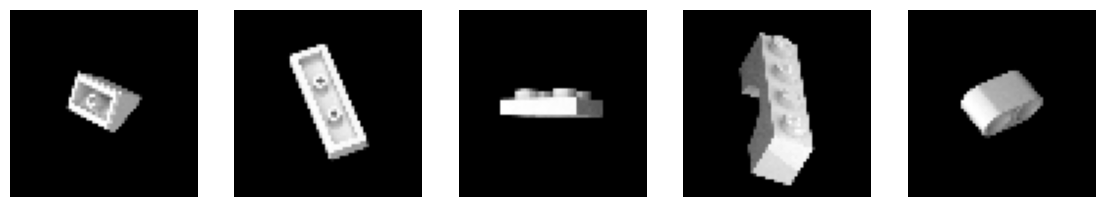

In [5]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)

plt.figure(figsize=(14, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(check_sample[i][0], cmap='gray')
    ax.axis('off')

plt.show()

## 2. Building GAN

In [25]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channels = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channels) - 1):
            conv_block = self.get_conv_block(channels[i], channels[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channels[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)


test = Discriminator().to(DEVICE)
summary(test, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,288
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
        Dropout2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

True
